# Kinetica Machine Learning: Sound Classification
Using the UltraSound8k training set we develop a convolutional neural net to classify different sounds with their appropriate labels. Labels are divided into 10 classes: **Air Conditioner, Car Horn, Children Playing, Dog Bark, Drilling, Engine Idling, Gun Shot, Jackhammer, Siren, Street Music**

In [113]:
from connector.kcudf import GPUdb
from connector.kmaputil import KMap
import IPython.display as ipd

# Load imports
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

## Visualize Audio File Waveforms

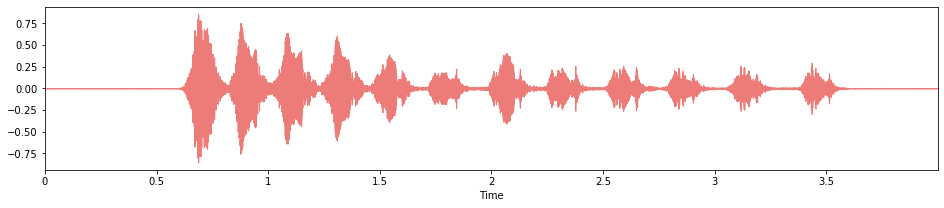

In [114]:
# Class: Dog Barking
filename = "./UrbanSound8k/audio/fold1/101415-3-0-3.wav"
plt.figure(figsize=(16,3))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate,color='#ed7b77')
ipd.Audio(filename)

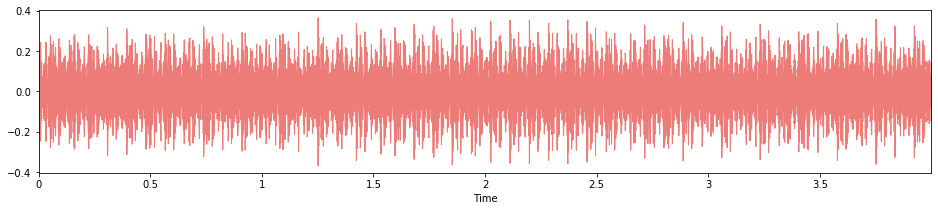

In [69]:
# Class: Engine Idling
filename = "./UrbanSound8k/audio/fold2/106015-5-0-12.wav"
plt.figure(figsize=(16,3))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate,color='#ed7b77')
ipd.Audio(filename)

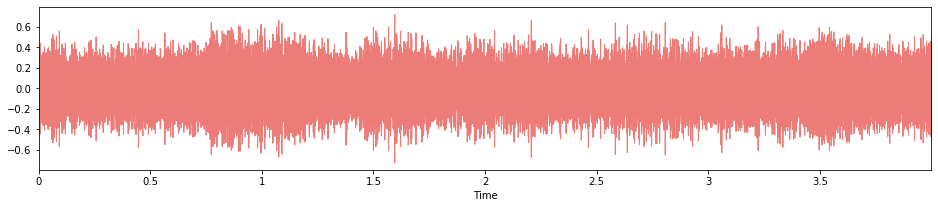

In [72]:
# Class: Drilling
filename = "./UrbanSound8k/audio/fold3/103199-4-2-2.wav"
plt.figure(figsize=(16,3))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate,color='#ed7b77')
ipd.Audio(filename)

## Inspect Metadata in Pandas

In [62]:
import pandas as pd
import sys, os, os.path
fulldatasetpath = './UrbanSound8k'
metadata = pd.read_csv(fulldatasetpath + '/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Extract Audio File Properties

In [81]:
import sys, os, os.path
import pickle


class WavFileHelper():

    def read_file_properties(self, filename):
        wave_file = open(filename, "rb")
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H',num_channels_string)[0]
        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

audiodata = []
fulldatasetpath = './UrbanSound8k'
wavfilehelper = WavFileHelper()
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'audio', 'fold' + str(row["fold"]) + '/',
                             str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)
    
# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels', 'sample_rate', 'bit_depth'])
audiodf.to_pickle("./audiodf.pkl")

## Vectorize Audio Files for Feature Representation

In [ ]:
import numpy as np
import struct

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T, axis=0)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return mfccsscaled

features = []
fulldatasetpath = './UrbanSound8k'
# Iterate through each sound file and extract the features
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath), 'audio','fold' + str(row["fold"]) + '/',
                             str(row["slice_file_name"]))

    class_label = row["class"]
    data = extract_features(file_name)
    features.append([data, class_label])

# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature', 'class'])
featuresdf.to_pickle("./featuresdf.pkl")

In [95]:
import pandas as pd
pd.options.display.max_columns = 100
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', 110)
file = pickle.load(open('./featuresdf.pkl', 'rb'))
featuresdf = pd.DataFrame(file)
featuresdf.head(5)

,feature,class
0,"[-215.793, 71.66612, -131.81377, -52.09133, -22.115969, -21.764181, -11.183747, 18.912683, 6.726639, 14.55...",dog_bark
1,"[-424.68686, 110.562294, -54.14824, 62.01074, -0.7095153, 18.157394, 1.4451556, 11.161129, -1.7058899, 12....",children_playing
2,"[-459.56473, 122.80033, -47.924713, 53.265697, -1.1398684, 24.772371, 7.9801335, 9.674258, -1.0235442, 11....",children_playing
3,"[-414.55374, 102.89688, -36.66496, 54.180405, 0.48600355, 15.6970625, 2.15513, 8.104217, -2.4878213, 10.01...",children_playing
4,"[-447.39703, 115.0954, -53.809113, 61.608585, 1.6425983, 26.112858, 1.9950668, 10.739073, 2.5962996, 10.63...",children_playing


## Create Train/Test Set for Model Tuning

In [102]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf["class"].tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## Model Training: Convolutional2D with TensorFlow

In [104]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import warnings
import tensorflow as tf
warnings.simplefilter('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [106]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(
    filepath='./SavedModel/weights.best.basic_mlp.hdf5',verbose=1,save_best_only=True)

start = datetime.now()

model.fit(
    x_train, 
    y_train, 
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_data=(x_test, y_test), 
    callbacks=[checkpointer], 
    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 0s 51us/step - loss: 9.6792 - accuracy: 0.2673 - val_loss: 2.7599 - val_accuracy: 0.4619

Epoch 00001: val_loss improved from inf to 2.75986, saving model to ./SavedModel/weights.best.basic_mlp.hdf5
Epoch 2/100
6985/6985 [==============================] - 0s 52us/step - loss: 2.8343 - accuracy: 0.2853 - val_loss: 1.9013 - val_accuracy: 0.3772

Epoch 00002: val_loss improved from 2.75986 to 1.90132, saving model to ./SavedModel/weights.best.basic_mlp.hdf5
Epoch 3/100
6985/6985 [==============================] - 0s 52us/step - loss: 1.9348 - accuracy: 0.3369 - val_loss: 1.6678 - val_accuracy: 0.4797

Epoch 00003: val_loss improved from 1.90132 to 1.66778, saving model to ./SavedModel/weights.best.basic_mlp.hdf5
Epoch 4/100
6985/6985 [==============================] - 0s 52us/step - loss: 1.7363 - accuracy: 0.3954 - val_loss: 1.4954 - val_accuracy: 0.5306

Epoch 00004: val_loss improve

## Validate on Test Set

In [109]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("\nTraining Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])


Training Accuracy:  0.925697922706604
Testing Accuracy:  0.8706353902816772


## Classify New Audio Files 

In [110]:
import librosa 
import numpy as np 

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])


def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

## Audio Sample to Predict

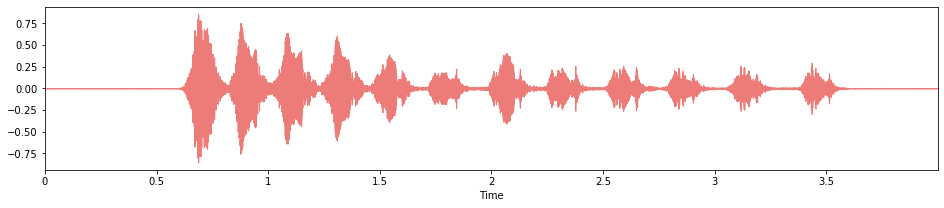

In [111]:
# Class: Dog Barking
filename = "./UrbanSound8k/audio/fold1/101415-3-0-3.wav"
plt.figure(figsize=(16,3))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate,color='#ed7b77')
ipd.Audio(filename)

In [112]:
print_prediction(filename)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00000000000000000000000000002830
car_horn 		 :  0.00000000000000000000106655609973
children_playing 		 :  0.00000000000000001180585836486612
dog_bark 		 :  1.00000000000000000000000000000000
drilling 		 :  0.00000000000000000239037619439808
engine_idling 		 :  0.00000000000000000000007300907678
gun_shot 		 :  0.00000000012167516993955018733686
jackhammer 		 :  0.00000000000000000000000000000000
siren 		 :  0.00000000000000002157294813036054
street_music 		 :  0.00000000019674334383878999688022
